In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

 # PSF Sub and Halo Finding

The code in this notebook is to test and showcase written functions for the python environment 'pycube'. It is designed to analyze MUSE data containers and the surrounding halo around QSOs and neighboring supermassive black holes. 

## Imports and data reading

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sep
from photutils import EllipticalAperture
import scipy as sp
from PIL import Image

import pycube
from pycube.core import background
from pycube.core import manip
from pycube import msgs
from pycube import core
from pycube import cubeClass
from pycube import psf
from pycube import halos
from pycube.instruments import vlt_muse
from IPython import embed
import math
import gc

There are three datasets that have been used for testing this program.

Random MUSE data (no LYa halo, but halo detection) <- Seyfert 1 galaxy

In [2]:
DATA_DIR = ('/home/ryan.foley/Downloads/ADP_MUSECOPY.fits')

--------------------

Initializes the class object 'test_cube' and initializes the data table by calling 'from_fits_file'. In the future this function will have multiple specifications for the second parameter for different instruments.


In [3]:
test_cube = cubeClass.IfuCube(DATA_DIR, vlt_muse)

Next we can initialize our test_cube object so that the various module's functions will operate on it.

In [4]:
test_cube.initialize_file()


This program is written with the assumption those using it know the RA and DEC of their object of interest. To recieve the coordinates in pixel value call the function object_coord from the manip module with your cube object, RA, & DEC as arguments.

In [5]:
# for ADPrandom
x_pos, y_pos = manip.object_coord(test_cube, 226.03207, -2.804395)

# Data Manipulation

The code is designed for users to specify how much of the container they want to analyze and on which axis they want to collapse upon. Given these are large data sets, analysis of a smaller section can be beneficial for hardware restraints. 

## Viewing Data

We can view the fits table which gives us the header descriptions of values and constants in the data as well as dimensions for our data container. For MUSE data we have a data set and 'stat' set, which is an equally sized variance cube of our data. 

In [7]:
del test_cube.hdul[3:] # deleted rows, as this was test data for write-to functions 
test_cube.hdul.info()

Filename: /home/ryan.foley/Downloads/ADP_MUSECOPY.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1355   ()      
  1  DATA          1 ImageHDU        44   (329, 316, 3681)   float32   
  2  STAT          1 ImageHDU        44   (329, 316, 3681)   float32   


The header file for the data row provides details about the various parameters stored within the data. 

In [8]:
test_cube.hdul[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  329 / length of data axis 1                          
NAXIS2  =                  316 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
OBJECT  = 'RXCJ1504.1-0248 (DATA)'                                              
CRPIX1  =     170.357588818887 / Pixel coordinate of reference point            
CRPIX2  =     156.543710915564 / Pixel coordinate of reference point            
CD1_1   = -5.55555555555556E-05 / Coordinate transformation matrix element      
CD1_2   =                   

## Cube Collapsing 

Here we can collapse along a range of wavelength values, which is our z-axis, to produce a flattened section of the cube. We test shape and also produce an image of the collapsed first 300 wavelengths. 

In [9]:
collapsed_300D, collapsed_300S = manip.collapse_container(test_cube, 0, 300)


In [10]:
np.shape(collapsed_300D)

(316, 329)

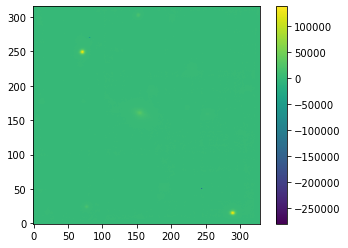

In [11]:
plt.imshow(collapsed_300D, origin = 'lower')
plt.colorbar()

Alternatively, we could not specify a range and the function will collapse the entire container.

In [12]:
collapsed_fullD, collapsed_fullS = manip.collapse_container(test_cube)


collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0


In [13]:
np.shape(collapsed_fullD)

(316, 329)

35

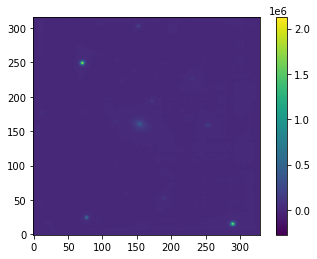

In [14]:
plt.imshow(collapsed_fullD, origin = 'lower')
plt.colorbar()

gc.collect()

## De-reddening

There is an added function to correct for de-reddening of the data from cosmic dust. This function converts the entire data container which can then be re-collapsed and analyzed. Our code currently uses the extinction package with a model of Fitzpatrick & Massa (2007)

In [15]:
deRed_fullD, deRed_fullS = manip.dust_correction(test_cube)

In [16]:
deRed_collapse = manip.collapse_cube(deRed_fullD)

collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0


In [17]:
np.shape(deRed_collapse)

(316, 329)

0

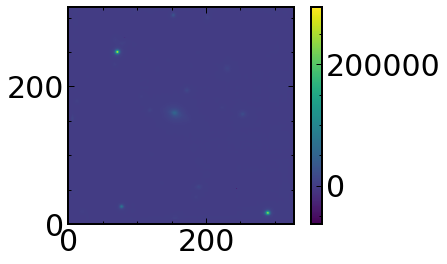

In [25]:
plt.imshow(deRed_collapse, origin='lower')
plt.colorbar()

gc.collect()
gc.collect()

# Background and Sources

## Background Sub

First we want to remove any residual sources in the background.

subtract_bg is a function which utilizes SEP to smooth the background after isolating the sources. SEP is a re-creation of SourceXtractor for Python. These functions and beyond have parameters that must be tuned for each data set. We read in our object for some functions, where as others require output from earlier functions. 

subtract_bg: Starting the procedure to subtract the background
stat_bg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Searching for sources in the collapsed cube
collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Detected 25 sources
stat_bg: Masking Edges
stat_bg: Masking sources
stat_bg: Performing b/g statistic


stat_bg: Saving debug image on /home/ryan.foley/Downloads/ADP_MUSECOPY.fits_BgRegion.pdf


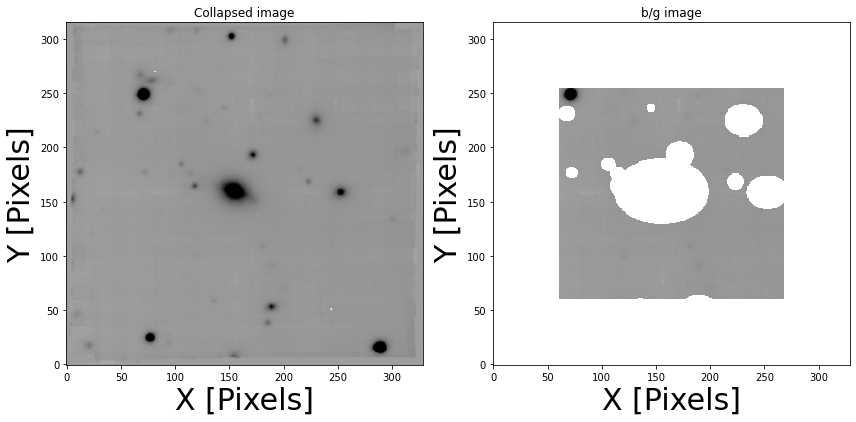

subtract_bg: Subtracting background from datacube
subtract_bg: Estimating correction for statcube variance
subtract_bg: The average correction factor for variance is 1.28593
nice_plot: Setting rcParams


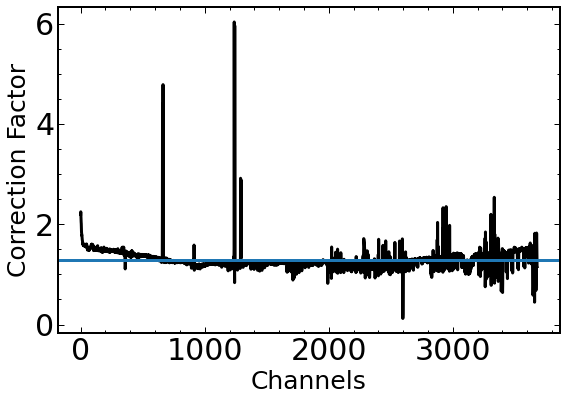

subtract_bg: The average value subtracted to the b/g level is 0.95095
nice_plot: Setting rcParams


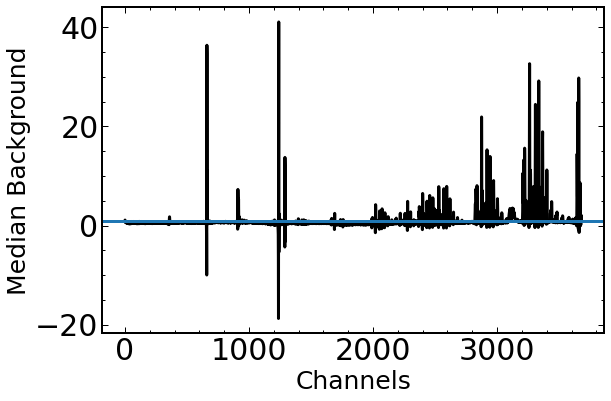

0

In [6]:
dataBg, statBg,_,_,_,_,_,_  = psf.subtract_bg(test_cube,
                                              sig_source_detect=0.05,
                                              min_source_area=2.,
                                              source_mask_size=5.,
                                              edges=60,
                                              output=DATA_DIR,
                                              debug=True,
                                              show_debug=True,
                                              sigma_clipping=True)
gc.collect()
gc.collect()

stat_bg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Searching for sources in the collapsed cube
collapse_container: Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_container: Invalid / unspecified minimum wavelength. Min value is set to 0
stat_bg: Detected 25 sources
stat_bg: Masking Edges
stat_bg: Masking sources
stat_bg: Performing b/g statistic


stat_bg: Saving debug image on /home/ryan.foley/Downloads/ADP_MUSECOPY.fits_BgRegion.pdf


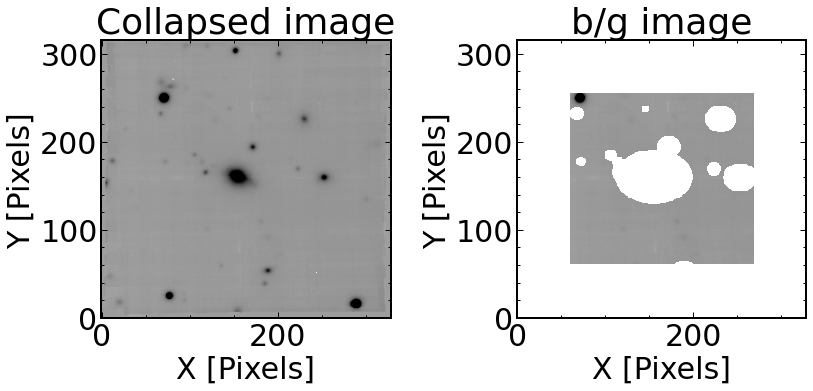

0

In [7]:
averageBg, medianBg, stdBg, varBg, pixelsBg, maskBg2D = psf.stat_bg(test_cube,
                                                                    sig_source_detect=0.05,
                                                                    min_source_area=2.,
                                                                    source_mask_size=5.,
                                                                    edges=60,
                                                                    output=DATA_DIR,
                                                                    debug=True,
                                                                    show_debug=True,
                                                                    sigma_clipping=True)
gc.collect()
gc.collect()

## Writing to File

Here we have a function which performs the above tasks of background isolation and source masking. It iterates through the entire cube, and writes the background and masks to the file. These code blocks are not active but are here to represent the availability of this function with the package.

Below it shows the now updated .fits with added rows for 'MASK' and 'BACKGROUND'.

We can showcase an example of the new sections by slicing a single wavelength and plotting the image. 

# Wavelengths

## Atmosphere 

We can also convert our channel values into wave lengths using the 'convert_to_wave' function from the manip module.
This function is utilized in other functions as well, but it stands on it's own for usability.

In [8]:
wavearray = manip.convert_to_wave(test_cube,test_cube.get_data())

Ploting the subtracted background average, median and sigma with the wave lengths yields the plot below. Notice that sigma is our atmospheric background.

8508

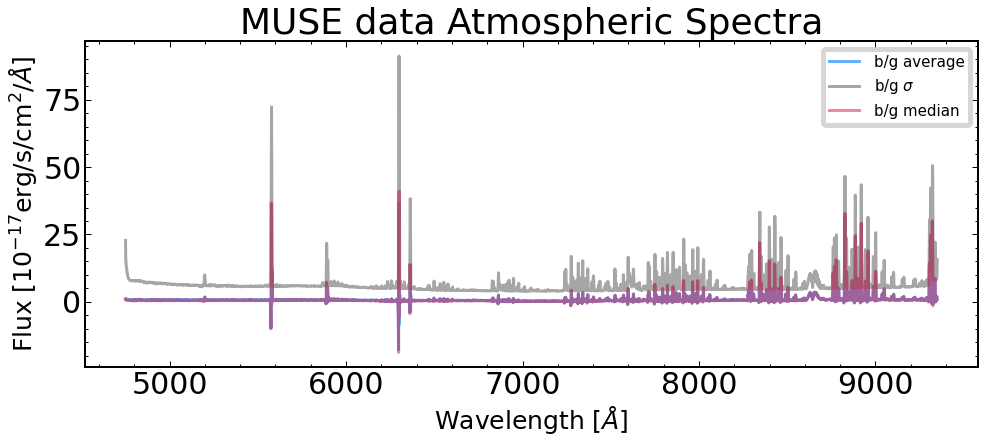

In [13]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray, averageBg, alpha=0.7, color='dodgerblue', label='b/g average')
plt.plot(wavearray, stdBg, alpha=0.7, color='grey', label='b/g $\sigma$')
plt.plot(wavearray, medianBg, alpha=0.5, color='crimson', label='b/g median')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.legend(prop={"size": 15})
plt.title('MUSE data Atmospheric Spectra')
gc.collect()

## Quasar Spectrum

Using the function 'q_spectrum' from the manip module, we can extract the spectra from the object of interest. This function assumes the RA and DEC of the object have been converted to pixel values.

In [14]:
fluxQso, errQso, bgQso = manip.q_spectrum(test_cube,x_pos,y_pos)
gc.collect()

8503

We can plot the the data wavelengths against this flux 

30

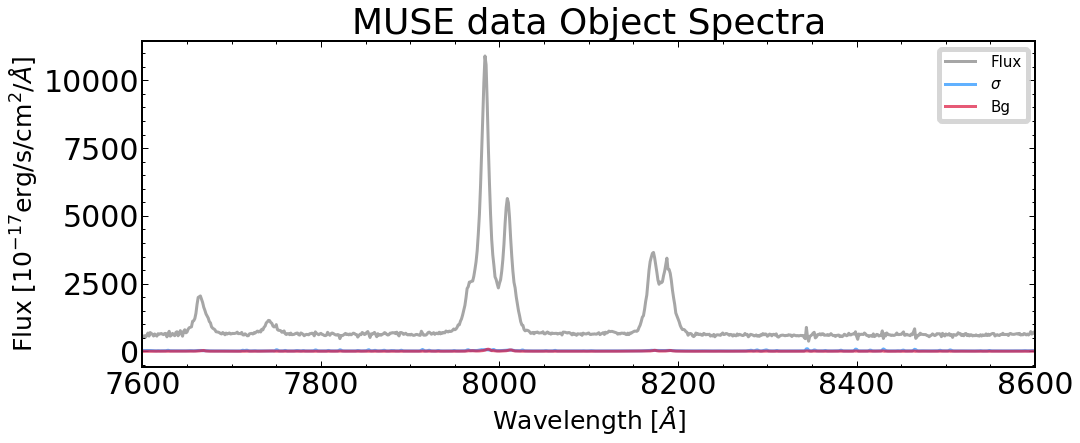

In [32]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(wavearray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(wavearray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('MUSE data Object Spectra')
plt.xlim(7600,8600)
plt.legend(prop={'size': 15})

gc.collect()

------------------

Another helpful function is to call .get_dimensions on the IFUcube object to quickly get its value ranges. Specifically, this is helpful to see the channel ranges of the previous plot.

In [38]:
z_max, y_max, x_max = test_cube.get_dimensions()
channelarray = np.arange(0,z_max, 1)

TypeError: convert_to_channel() missing 1 required positional argument: 'datacube'

8913

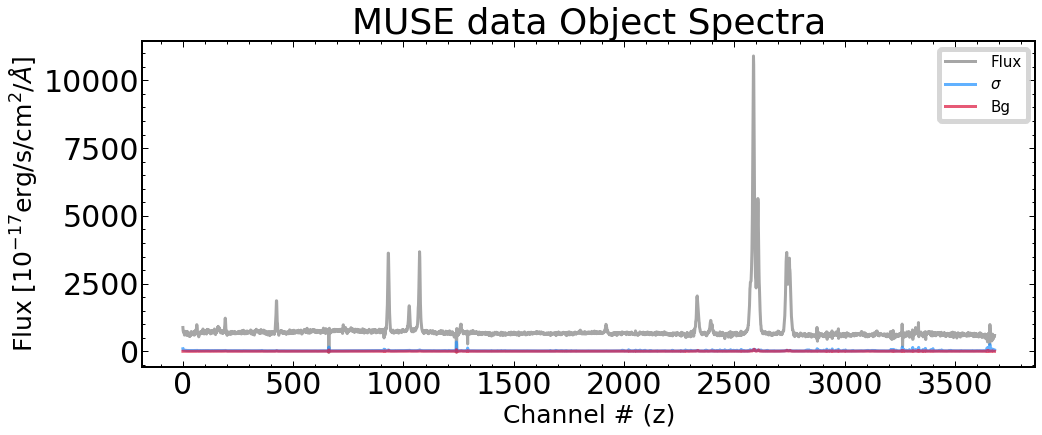

In [27]:
plt.figure(0, figsize=(16,6))
plt.plot(channelarray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(channelarray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(channelarray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Channel # (z)')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('MUSE data Object Spectra')
plt.legend(prop={'size': 15})

gc.collect()

 From this plot, we can easily visualize the channel values where we need to cut off / shrink the cube to perform the following functions in the package.

 ----------------

# Point Spread Function

The following code impliments a point-spread function to remove the highly luminous QSO (or other source) to isolate the potential surround halo.

## PSF Creation

The first step is to normalize the flux produced by the QSO. using c_type=sum does just this. We also need to perform this function along the continuum just beyond were we estimate our LYa emission to be.

create_psf: Creating PSF model
create_psf: Summing channels
quick_ap_photometry: Performing aperture photometry
Source 1 : Aperture photometry on source at: 156.8755888186492, 160.77371091556373
create_psf: Removing local background of [10.72676945]
create_psf: Normalizing central region to 1
         (i.e. correcting for a factor [39245.09197561]
create_psf: Creating circular mask around the position 156.8755888186492, 160.77371091556373
location: single source identified
create_psf: Creating debug images
nice_plot: Setting rcParams


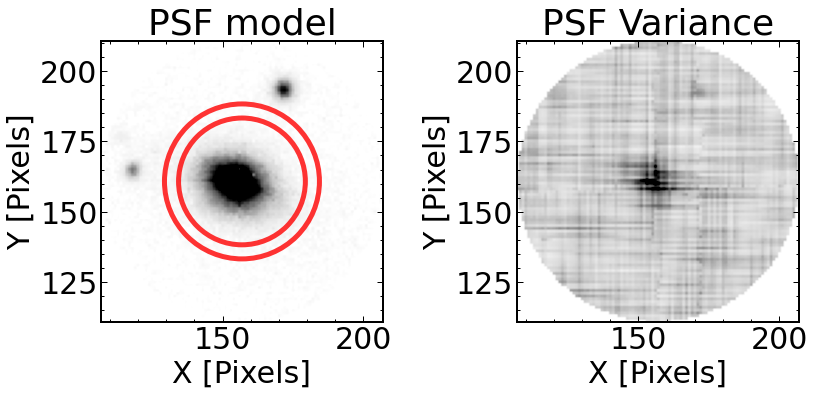

0

In [33]:
psf_data, psf_stat = psf.create_psf(dataBg,statcube=statBg,x_pos=x_pos,y_pos=y_pos,
                                    inner_rad=45,outer_rad=55,
                                    min_lambda=1500,max_lambda=1550,
                                    debug = True,show_debug=True, c_type = 'sum')
gc.collect()
gc.collect()

-------------

## PSF Cleaning

The function 'clean_psf' from the fitting psf module takes the now normalized psf model and subtracts the contribution.

clean_psf: PSF subtraction on cube
clean_psf: The min, max values for PSF model are: -0.0040, 0.1183
clean_psf: Spectrum of the source
nice_plot: Setting rcParams


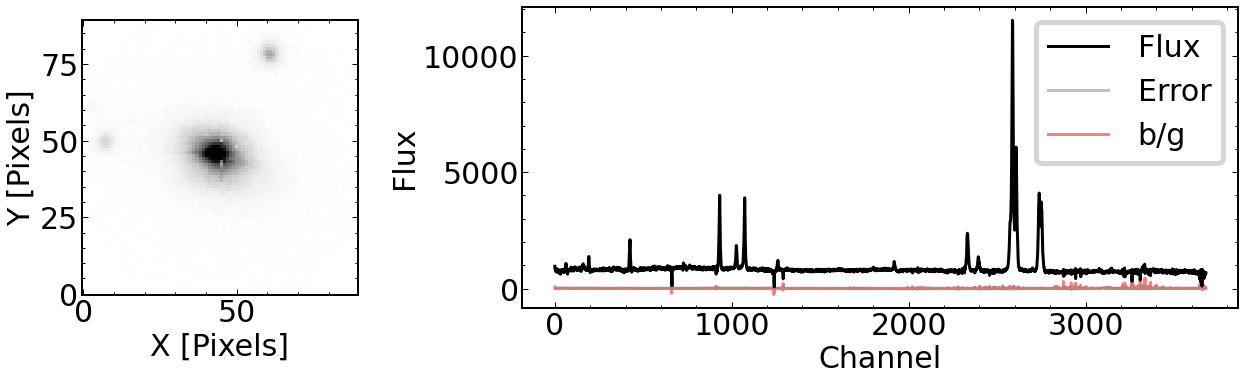

clean_psf: PSF cleaning performed


0

In [34]:
dataCubeClean, dataCubeModel = psf.clean_psf(test_cube,
                                             psf_model=psf_data,
                                             x_pos=x_pos,y_pos=y_pos,
                                             debug=True,radius_pos=2.,
                                             inner_rad=45.,outer_rad=55.,
                                             show_debug = True) 
gc.collect()
gc.collect()

# Halo Finding

To preserve memory and remain accurate, we use two parameters here to smooth our data. These are the background corrected data and variance cubes. The function 'smoothChiCube' smooths the cube in the spatial (a_smooth) and spectral (v_smooth) axes.

We use the above plots to set our shrinking parameters min and max lambda.

## Cube Smoothing

In [41]:
chiCube, sChiCube = halos.smooth_chicube(dataCubeClean,statcube=statBg,
                                         min_lambda=2600,
                                         max_lambda=2615,
                                         a_smooth=1,
                                         v_smooth=2)
np.shape(sChiCube)

smooth_chicube: Shrinking cube with given parameters
smooth_chicube: Smoothing cube with 3D Gaussian Kernel


(15, 316, 329)

----------------

## Halo Mask

halo_mask is the crucial function to the halo finding module. This function performs a friend of friend algorith from a high value voxel nearby the source on the now smoothed and background corrected cube. 

halo_mask: removing inner region around (x,y)=(156.88,160.77)
          with radius 2 pixels
location: single source identified
halo_mask: removing outer region around (x,y)=(156.88,160.77)
          with radius 40 pixels
location: single source identified
halo_mask: defining threshold level
stat_fullcube: statistic on the cube
stat_fullcube: average = -0.886
              median  = -0.467
              sigma   = +2.431
stat_fullcube_z: statistic on the cube
halo_mask: the median value of the voxels is: -0.4667
          and the sigma is: +2.4312
halo_mask: the average relative threshold value set to 1.50*2.4312=3.6467
halo_mask: Saving debug image on Object_voxelDistribution.pdf
          in principle the distribution should be gaussian
          showing only channel 7
nice_plot: Setting rcParams


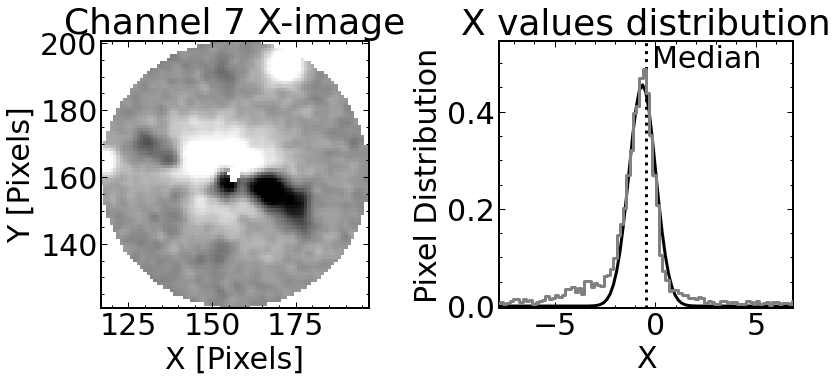

halo_mask: searching for extended emission
          starting from from (x,y,z)=(156.88,160.774,7)
halo_mask: the maximum S/N detected is 13.285 
          at the location (x,y,z)=(151,161,12)
halo_mask: starting to fill the halo mask
halo_mask: Creating debug image
          Plotting Channel 12 where the most significant voxel is.
          The location of this voxel is marked with a red circle
          The position of the quasar is in blue
nice_plot: Setting rcParams
spectral_mask_halo: collapsing halo mask
halo_mask: debug image saved in Object_maskHaloStartingVoxel.pdf


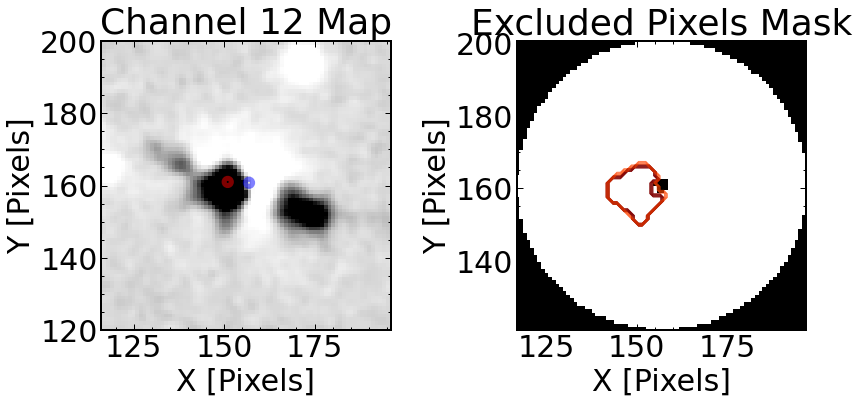

0

In [43]:
maskHalo = halos.halo_mask(sChiCube,
                           x_pos=x_pos,
                           y_pos=y_pos,
                           z_pos=7,
                           rad_bad_pix=2,
                           rad_max=40,
                           r_connect=2,
                           threshold=1.5,
                           threshold_type='relative',
                           bad_pixel_mask=None,
                           output='Object',
                           debug=True,
                           show_debug=True)
gc.collect() 
gc.collect()